# Graph Spectral Image Processing - Part II

This jupyter notebook aims at illustrating the concepts introduced in the lecture. It relies on pygsp library whose documentation is available [here](https://pygsp.readthedocs.io/en/v0.4/index.html). It contains tutorials and excerices. This second notebook is organized as follows:

- [1 - Graph Filter](#1-graph-filters)
- [2 - Graph translation](#-graph-translation)
- [3 - Graph reduction](#-graph-reduction)

In [2]:
import numpy as np
import pygsp as gp
import scipy as sp
from pygsp import graphs, filters
from pygsp.utils import build_logger
import matplotlib.pyplot as plt
from matplotlib import image
from scipy.stats import norm
from pygsp import plotting




For this notebook, we will take the example of a 2D grid graph on which the signal is a piece of the lena picture

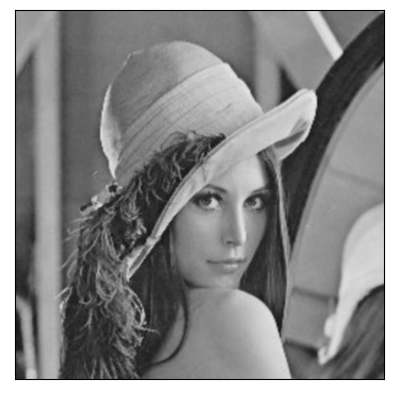

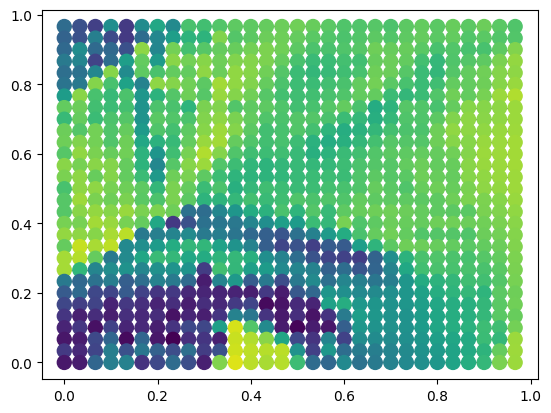

In [3]:

# load image as pixel array
img = image.imread('lena.jpg')

plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

N = 30
G = gp.graphs.Grid2d(N1=N,N2=N)
i1 = 105
i2 = 125
signal = img[i1:i1+N,i2:i2+N]


# signal creation
signalV = signal.flatten()

G.plot_signal(signalV, colorbar=False, plot_name='', save_as='input')




We also create a graph in which the weights depend on the input signal

In [4]:
# create 
Gw = gp.graphs.Grid2d(N1=N,N2=N)

for i in range(N*N):
    for j in range(i,N*N):
       if Gw.A[i,j] == 1:
            Gw.W[i,j] =  np.exp(-1*np.abs(int(signalV[i])-int(signalV[j]))/10)
            Gw.W[j,i] =  Gw.W[i,j]

Let us first make an experiment to evaluate the importance of having meaningful weights. We will evaluate how much the first transform coefficients capture the signal information, when using adjusted weights or not

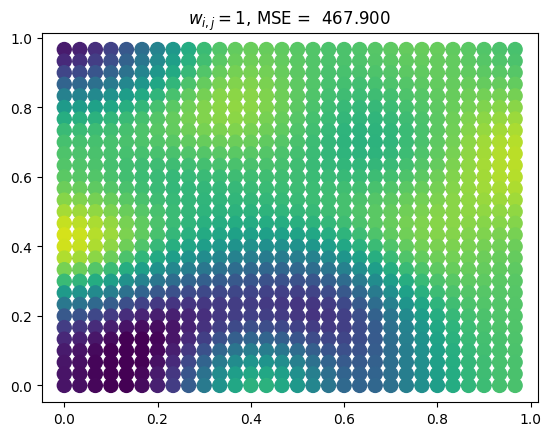

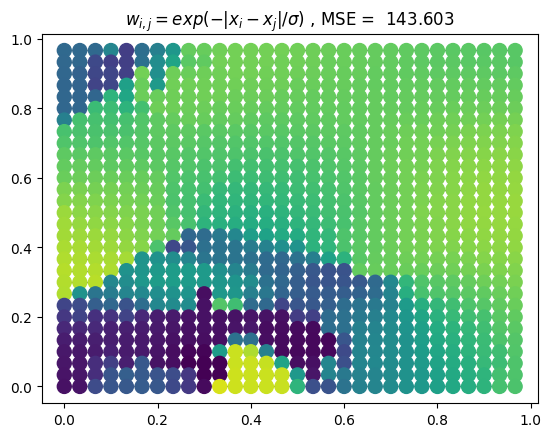

In [5]:
Gw.compute_laplacian()
Gw.compute_fourier_basis(N*N)
G.compute_laplacian()
G.compute_fourier_basis(N*N)


t = G.gft(signalV)
tw = Gw.gft(signalV)

comp = 30 #number of non zero coefficients (which means 3,3%)
t[comp:len(t)] = 0
tw[comp:len(tw)] = 0

signalR = G.igft(t)
signalRw = Gw.igft(tw)

mse = (np.square(signalR - signalV)).mean()
msew = (np.square(signalRw - signalV.astype(float))).mean()

G.plot_signal(signalR,  colorbar=False, plot_name='$w_{i,j}=1$, MSE =  %1.3f' % mse, save_as='no_weight')
G.plot_signal(signalRw,  colorbar=False, plot_name='$w_{i,j}=exp(-|x_i-x_j|/\sigma)$ , MSE =  %1.3f' % msew, save_as='weight')


plt.show()
end = 1

We can see that the MSE and visual accuracy of the weighted graph is better. Let us see how this can help graph filtering in the next section

<a id='1-graph-filters'></a> 
# 1 - Graph filter

First task, is to import the pygsp library and other useful libraries for general signal processing and mathematics

Let us create a noisy signal


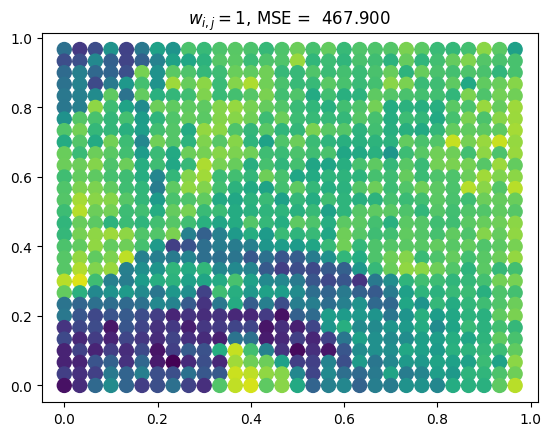

In [6]:
mu = 10;
signalV_noisy = signalV + mu*np.random.normal(size=G.N)

G.plot_signal(signalV_noisy,  colorbar=False, plot_name='$w_{i,j}=1$, MSE =  %1.3f' % mse, save_as='no_weight')


see this [link](https://pygsp.readthedocs.io/en/stable/reference/filters.html) for some filter implemented in PyGSP 

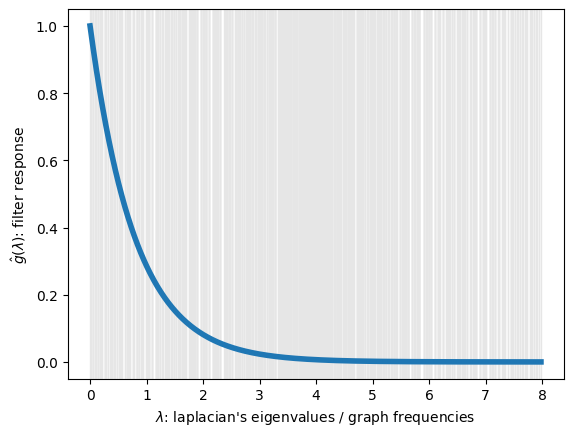

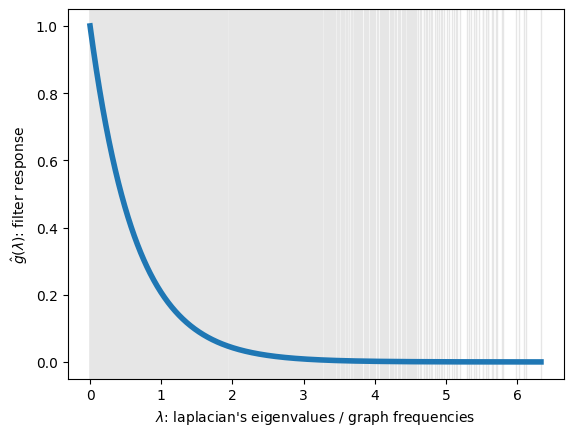

In [7]:
#create one low pass filter
tau=10
g = filters.Heat(G,tau)
gw = filters.Heat(Gw,tau)

g.plot()
gw.plot()

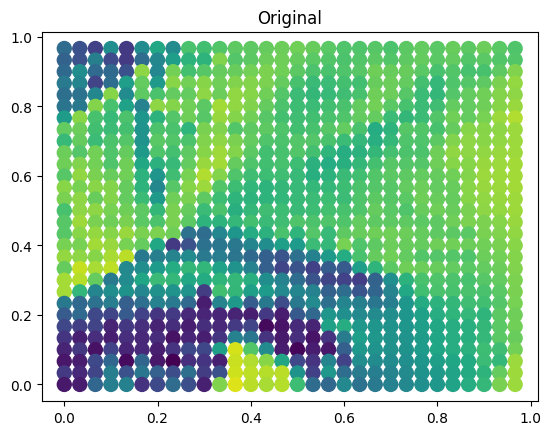

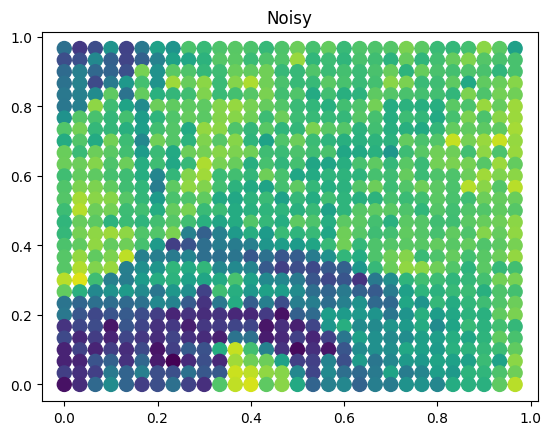

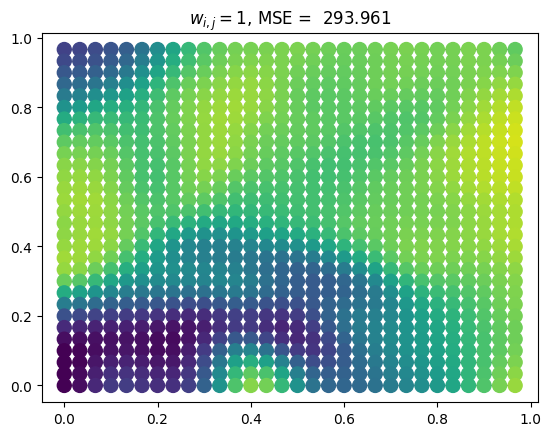

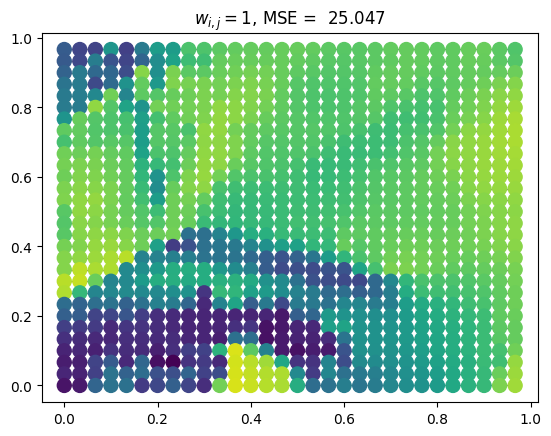

In [9]:
signalV_filtered = g.filter(signalV_noisy)
signalV_filtered_w = gw.filter(signalV_noisy)

mse_filtered = (np.square(signalV_filtered - signalV)).mean()
mse_filtered_w = (np.square(signalV_filtered_w - signalV.astype(float))).mean()

G.plot_signal(signalV,  colorbar=False, plot_name='Original' % mse_filtered, save_as='no_weight')
G.plot_signal(signalV_noisy,  colorbar=False, plot_name='Noisy' % mse_filtered, save_as='no_weight')
G.plot_signal(signalV_filtered,  colorbar=False, plot_name='$w_{i,j}=1$, MSE =  %1.3f' % mse_filtered, save_as='no_weight')
G.plot_signal(signalV_filtered_w,  colorbar=False, plot_name='$w_{i,j}=1$, MSE =  %1.3f' % mse_filtered_w, save_as='no_weight')


<a id='2-graph-translation'></a> 
# 2. Graph Translation

Let us see the spectral translation of a localized signal

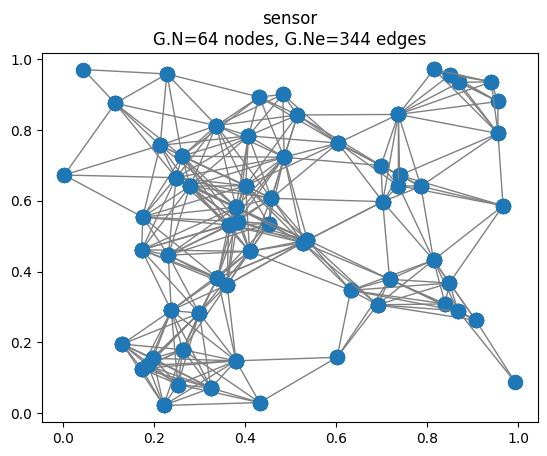

In [10]:
G = graphs.Sensor()
G.compute_laplacian('normalized')
G.compute_fourier_basis()
G.plot() 

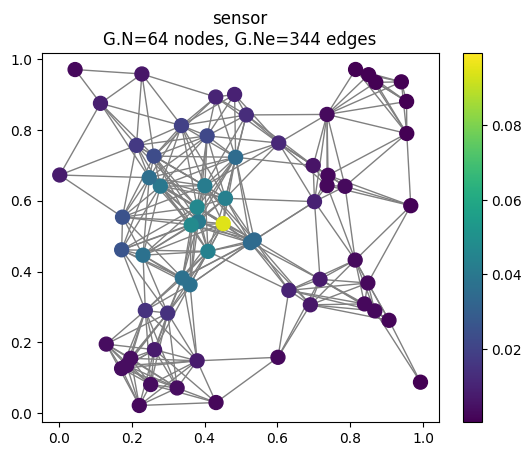

In [11]:
# we define the signal as a gaussian function
i0 = 1
neighborhood = 4
signal = np.zeros(G.N)
signal[i0]=1
g = filters.Heat(G,neighborhood)
signal = g.filter(signal)

G.plot_signal(signal)

We translate the signal based on the spectral definiton of the translation

In [12]:
def translate(G, f, i):
    r"""
    Tranlate the signal f to the node i

    Parameters
    ----------
    G : Graph
    f : ndarray
        Signal
    i : int
        Indices of vertex

    Returns
    -------
    ft : translate signal

    """
    G.compute_fourier_basis()
    fhat = G.gft(f)

    
    ft = np.sqrt(G.N)*G.igft(fhat * G.U[i,:])

    return ft

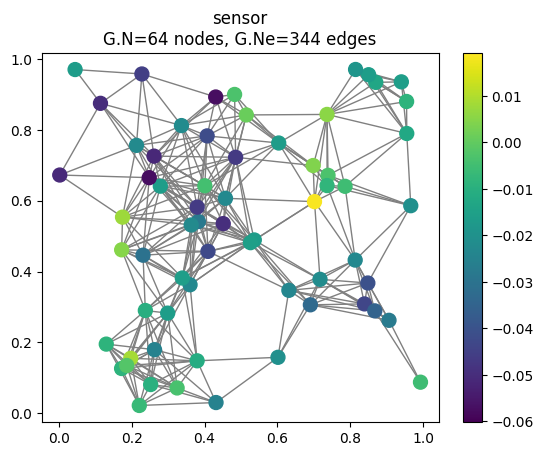

In [13]:
it = 1
signal_translated = translate(G, signal, it)
G.plot_signal(signal_translated)